# Final Project Code Part 4 Improved AE On CIFAR10

**Name: Yiqun Hao**

**Content**: In this notebook:


1. I did experiments on CIFAR10 using the code from part 3: the network with "push" operation having AE removed. 

#### Import all packages used in this notebook

In [1]:
# Main package: PyTorch
import torch
# TorchVision contains image datasets
import torchvision
# Our networks
import torch.nn as nn
# Our activation
import torch.nn.functional as F
# Optimizer
import torch.optim as optim

# Draw graphs to visualize
import matplotlib.pyplot as plt
import numpy as np

#### 0. Check GPU

In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


#### CAE Model Parameters

In [3]:
# lambda's are the ratios between the four error terms
# lambda_class = 20
lambda_class = 10
lambda_1 = 1              # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# the number of prototypes
n_prototypes = 15

#### 1. We first import dataset

In [4]:
n_epochs = 100
batch_size = 50
learning_rate = 0.0005
momentum = 0.5
random_seed = 1
torch.manual_seed(random_seed)

In [5]:
# 1. We first construct a transform to normalize image data
transform = torchvision.transforms.Compose([
    # To [0,1]
    torchvision.transforms.ToTensor(),
    # To [-1,1] first () is the mean of RGB second () is the std of RBG
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
# 2. We import data
train_set = torchvision.datasets.CIFAR10(root='./dataset',train=True,download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./dataset',train=False,download=True,transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#### 2. We construct our network 

##### 1. Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv8 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.fc14 = nn.Linear(512 * 4 * 4, 1024)
        self.drop1 = nn.Dropout2d()
        self.fc15 = nn.Linear(1024, 1024)
        self.drop2 = nn.Dropout2d()
        self.fc16 = nn.Linear(1024, 40)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        # print(" x shape ",x.size())
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc14(x))
        x = self.drop1(x)
        x = F.relu(self.fc15(x))
        x = self.drop2(x)
        x = self.fc16(x)
        
        return x
print(Encoder())

Encoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=1, 

In [7]:
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5, stride = 2)
#         self.conv2 = nn.Conv2d(6, 16, 5, stride = 2)
#         self.fc1 = nn.Linear(400, 40)

#     def forward(self, x):
#         # Input: 3 * 32 * 32 = 3072
#         # 1. 6 * 14 * 14 = 1176  or 6*15*15
#         x = F.relu(self.conv1(x))

#         # 3. 16 * 5 * 5 = 400
#         x = F.relu(self.conv2(x))

#         # Flatten layer
#         x = x.view(-1, 400)

#         # Enter into classification
#         x = F.relu(self.fc1(x))
#         return x
    
#         return x
# # print(Encoder())

##### 2. Prototype Classification Network

In [8]:
# Functions used to calculate the distance between encoded_input and prototype vectors
def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = list_of_norms(X).view(-1, 1)
    YY = list_of_norms(Y).view(1, -1)
    output = XX + YY - 2 * torch.matmul(X, Y.t())

    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X,2), axis=1)

In [9]:
class PCN(nn.Module):
    def __init__(self):
        super(PCN, self).__init__()
        self.prototype_feature_vectors = nn.Parameter(torch.rand(n_prototypes, 40))
        



# x.shape:  torch.Size([100, 10, 2, 2])
# feature_vectors.shape:  torch.Size([100, 40])
# prototype_feature_vectors.shape:  torch.Size([10, 40])
# feature_vector_distances.shape is the list of distances from each prototype to every x_i in the latent space:  torch.Size([10, 100])
# prototype_distances.shape is the list of distances from each x_i to every prototype in the latent space :  torch.Size([100, 10])
    def forward(self, feature_vectors):
        
        # ----------------------------------------------------------------------------------------------------------
        # Prototype layer
        prototype_distances = list_of_distances(feature_vectors, self.prototype_feature_vectors)
        feature_vector_distances = list_of_distances(self.prototype_feature_vectors, feature_vectors)



        # ----------------------------------------------------------------------------------------------------------

        # Fully-connected layer
        output = prototype_distances * -1
        return output, prototype_distances, feature_vector_distances, self.prototype_feature_vectors


    
print(PCN())

PCN()


In [10]:
class LastLayer(nn.Module):
    def __init__(self):
        super(LastLayer, self).__init__()
        self.fl = nn.Linear(n_prototypes, 10, bias=False)

    def forward(self, x):
        x = self.fl(x)
        return x
    def showWeight(self):
        print(self.fl.weight) 
print(LastLayer())

LastLayer(
  (fl): Linear(in_features=15, out_features=10, bias=False)
)


#### Overall Model

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = Encoder()
        self.pcn = PCN()
        self.lastLayer = LastLayer()

    def forward(self, x):
        encoded_input = self.encoder(x)
        output, prototype_distances, feature_vector_distances, prototype_vectors = self.pcn(encoded_input)
        output = self.lastLayer(output)
        return encoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors
    
    def showWeight(self):
        self.lastLayer.showWeight()
    
    
print(MyModel())

MyModel(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (pool

#### Loss Function

In [12]:
'''
the error function consists of 4 terms, the autoencoder loss,
the classification loss, and the two requirements that every feature vector in
X look like at least one of the prototype feature vectors and every prototype
feature vector look like at least one of the feature vectors in X.
'''
class LossFunc(nn.Module):
    def __init__(self):
        super(LossFunc, self).__init__()
        self.crossLoss = nn.CrossEntropyLoss()

    def forward(self, outputs, labels, images, feature_vector_distances, prototype_distances):
        class_error = self.crossLoss(outputs,labels)
        error_2 = torch.mean(torch.min(prototype_distances, axis = 1).values)
        error_1 = torch.mean(torch.min(feature_vector_distances, axis = 1).values)
        total_error = lambda_class * class_error +\
                      lambda_1 * error_1 +\
                      lambda_2 * error_2
        return class_error, error_1, error_2, total_error 

#### 3. We train our network on training dataset and evaluate them on the test set

In [13]:
# 1. Initial networks
model = MyModel()
model = model.cuda()

# 3. Store things for visualizing results
accuracy_values=[]
total_loss_values=[]
error1_loss_values=[]
error2_loss_values=[]
class_loss_values=[]
epoch_number=range(n_epochs)



# 4. Begin training
criterion = LossFunc()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 
optimizer = optim.SGD(model.parameters(), lr=learning_rate) 

for epoch in epoch_number:
    running_loss = 0.0
    running_class = 0.0
    running_e1 = 0.0
    running_e2 = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        encoded_input, output, prototype_distances, feature_vector_distances, _ = model(inputs)
        # X_true not defined
        class_error, error_1, error_2, total_error = criterion(output, labels, inputs, feature_vector_distances, prototype_distances)
        total_error.backward()
        optimizer.step()

        # print statistics
        running_loss += total_error.item()
        running_class += class_error.item()
        running_e1 += error_1.item()
        running_e2 += error_2.item()
    
        if i % 1000 == 999:    # print every 6000 mini-batches (12500 batches in total)
            print('[epoch: %d, itr: %5d] total_loss: %.6f class_error: %.6f error_1: %.6f error_2: %.6f' %
                (epoch + 1, i + 1, running_loss/100, running_class/100, running_e1/100, running_e2/100))

            total_loss_values.append(running_loss/100)
            error1_loss_values.append(running_e1/100)
            error2_loss_values.append(running_e2/100)
            class_loss_values.append(running_class/100)

            running_loss = 0.0
            running_class = 0.0
            running_e1 = 0.0
            running_e2 = 0.0


    # Evaluate our dataset on test set
    correct = 0
    total = 0
#     model.showWeight()
    # Make parameters stay the same without updating
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        encoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors = model(images)
        # Return the value, index pair of the biggest element. Max function 1 means the biggest in each row, 0 means biggest in each column
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu()==labels.cpu()).sum().item()
        
#       model.presentPrototype(prototype_vectors)
#       model.presentDecoded(encoded_input)
      TestAccuracy = 100 * correct / total;
      accuracy_values.append(TestAccuracy) 
      print('Epoch=%d Test Accuracy=%.2f%%' %
                (epoch + 1, TestAccuracy))
    
    

print('Finished Here!')

C:\Users\EZRA\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[epoch: 1, itr:  1000] total_loss: 220.514117 class_error: 17.531983 error_1: 26.158369 error_2: 19.035915
Epoch=1 Test Accuracy=49.63%
[epoch: 2, itr:  1000] total_loss: 155.440421 class_error: 12.177822 error_1: 18.405302 error_2: 15.256896
Epoch=2 Test Accuracy=62.20%
[epoch: 3, itr:  1000] total_loss: 125.987001 class_error: 9.840989 error_1: 14.416417 error_2: 13.160699
Epoch=3 Test Accuracy=67.68%
[epoch: 4, itr:  1000] total_loss: 104.828850 class_error: 8.169004 error_1: 11.700933 error_2: 11.437881
Epoch=4 Test Accuracy=71.92%
[epoch: 5, itr:  1000] total_loss: 89.126115 class_error: 6.905399 error_1: 9.876180 error_2: 10.195941
Epoch=5 Test Accuracy=74.03%
[epoch: 6, itr:  1000] total_loss: 76.640782 class_error: 5.899022 error_1: 8.416981 error_2: 9.233583
Epoch=6 Test Accuracy=76.08%
[epoch: 7, itr:  1000] total_loss: 65.679193 class_error: 5.017544 error_1: 7.201651 error_2: 8.302105
Epoch=7 Test Accuracy=75.99%
[epoch: 8, itr:  1000] total_loss: 57.441614 class_error: 4.3

Epoch=62 Test Accuracy=82.25%
[epoch: 63, itr:  1000] total_loss: 1.548481 class_error: 0.016658 error_1: 0.504364 error_2: 0.877536
Epoch=63 Test Accuracy=82.01%
[epoch: 64, itr:  1000] total_loss: 1.502677 class_error: 0.014870 error_1: 0.488653 error_2: 0.865319
Epoch=64 Test Accuracy=82.15%
[epoch: 65, itr:  1000] total_loss: 1.491471 class_error: 0.014831 error_1: 0.489825 error_2: 0.853331
Epoch=65 Test Accuracy=81.97%
[epoch: 66, itr:  1000] total_loss: 1.481939 class_error: 0.014369 error_1: 0.486762 error_2: 0.851490
Epoch=66 Test Accuracy=82.26%
[epoch: 67, itr:  1000] total_loss: 1.487544 class_error: 0.016179 error_1: 0.480858 error_2: 0.844894
Epoch=67 Test Accuracy=82.39%
[epoch: 68, itr:  1000] total_loss: 1.452024 class_error: 0.014270 error_1: 0.472519 error_2: 0.836805
Epoch=68 Test Accuracy=82.22%
[epoch: 69, itr:  1000] total_loss: 1.478295 class_error: 0.015737 error_1: 0.495042 error_2: 0.825882
Epoch=69 Test Accuracy=82.16%
[epoch: 70, itr:  1000] total_loss: 1.4

#### Push each prototype to the closest sample 

In [14]:
closed_samples = [1000 for i in range(n_prototypes)]
closed_distances = [1000 for i in range(n_prototypes)]
closed_labels = ['label' for i in range(n_prototypes)]

with torch.no_grad():
    for x, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        if x == 0:
            print(labels[0])
                
        _, _, _, feature_vector_distances, _ = model(inputs)
        feature_vector_distances = feature_vector_distances.cpu().tolist()
        
        # feature_vector_distances is the list of distances from each prototype to every x_i in the latent space torch.Size([10, 100])
        for i in range(n_prototypes):
            for j in range(len(feature_vector_distances[i])):
                if(feature_vector_distances[i][j] < closed_distances[i]):
                    closed_distances[i] = feature_vector_distances[i][j]
                    closed_samples[i] = inputs[j].cpu()
                    closed_labels[i] = labels[j].cpu()

tensor(2, device='cuda:0')


#### Visualize Prototypes

<class 'list'>


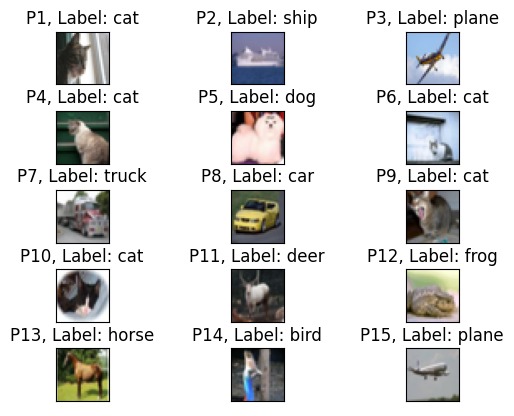

In [15]:
classes = ['plane','car','bird','cat','deer', 'dog','frog','horse','ship','truck']
x = closed_samples
print(type(x))
fig = plt.figure()
plt.subplots_adjust(hspace=0.5)
for i in range(n_prototypes):
    plt.subplot(5,n_prototypes//5,i+1)
    img = torchvision.utils.make_grid(x[i])
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("P{}, Label: {}".format(i+1, classes[closed_labels[i]]))
    plt.xticks([])
    plt.yticks([])
plt.show()

#### 5. Visualize our performance results

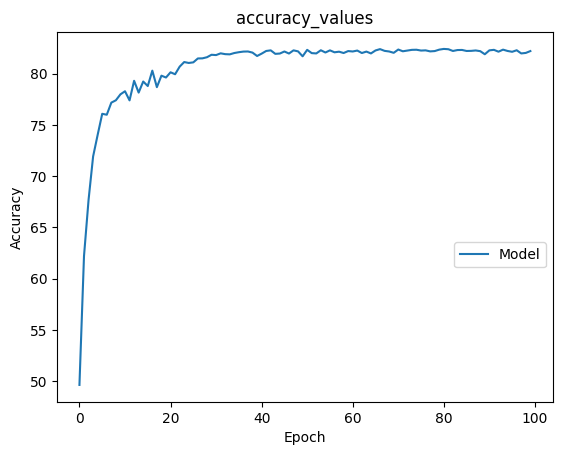

In [16]:
# First we check values we have so far
# print('accuracy_values', accuracy_values)
# print('epoch_number', epoch_number)
# Plot the data
plt.plot(epoch_number, accuracy_values, label='Model')  
plt.title('accuracy_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('Accuracy')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

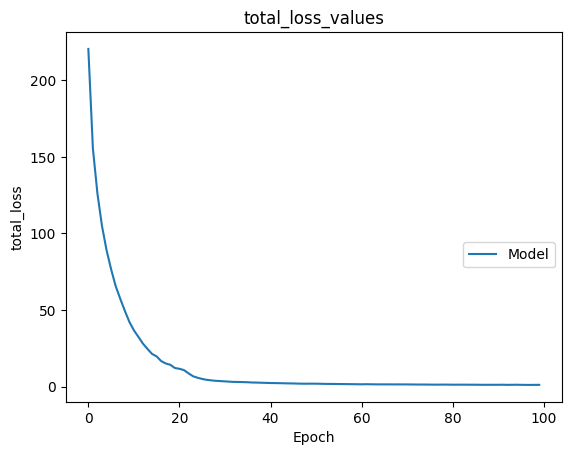

In [17]:
# Plot the data
plt.plot(epoch_number, total_loss_values, label='Model')  
plt.title('total_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('total_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

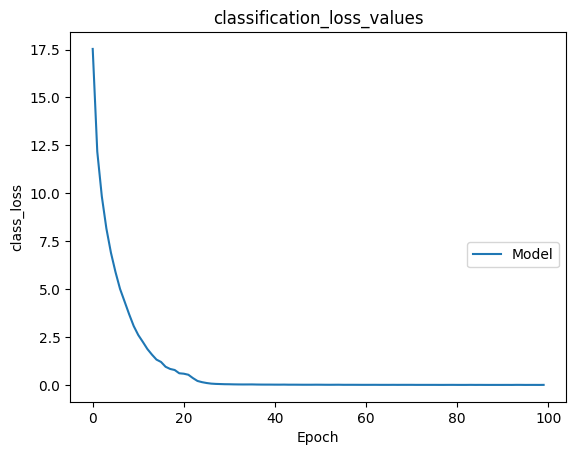

In [18]:
# Plot the data
plt.plot(epoch_number, class_loss_values, label='Model')  
plt.title('classification_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('class_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

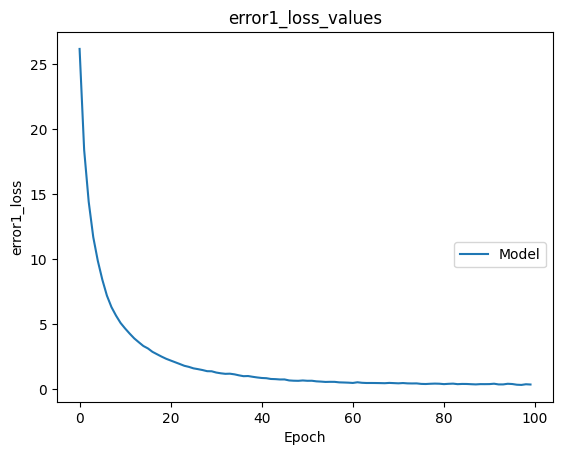

In [19]:
# Plot the data
plt.plot(epoch_number, error1_loss_values, label='Model')  
plt.title('error1_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('error1_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

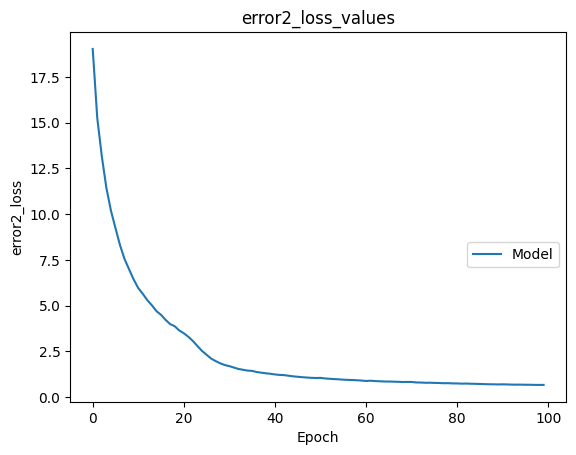

In [20]:
# Plot the data
plt.plot(epoch_number, error2_loss_values, label='Model')  
plt.title('error2_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('error2_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

#### Do more analysis on the final model to see how well it deals with each class

In [21]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
all_class_correct = list(0. for i in range(10))
all_class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in test_loader:
        images =images.cuda()
        labels =labels.cuda()
        _, outputs, _, _, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels)

        
        for i in range(batch_size):
            label = labels[i]
            all_class_correct[label] += c[i].item() # True is deemed as 1
            all_class_total[label] += 1



for i in range(10):
    print("all class total: ", all_class_total[i]," all class correct: ", all_class_correct[i])
    print('For network: Model Accuracy of %5s : %2d %%' % 
          (classes[i], 100 * all_class_correct[i] / all_class_total[i]))

all class total:  1000.0  all class correct:  854.0
For network: Model Accuracy of     0 : 85 %
all class total:  1000.0  all class correct:  906.0
For network: Model Accuracy of     1 : 90 %
all class total:  1000.0  all class correct:  751.0
For network: Model Accuracy of     2 : 75 %
all class total:  1000.0  all class correct:  679.0
For network: Model Accuracy of     3 : 67 %
all class total:  1000.0  all class correct:  806.0
For network: Model Accuracy of     4 : 80 %
all class total:  1000.0  all class correct:  736.0
For network: Model Accuracy of     5 : 73 %
all class total:  1000.0  all class correct:  836.0
For network: Model Accuracy of     6 : 83 %
all class total:  1000.0  all class correct:  859.0
For network: Model Accuracy of     7 : 85 %
all class total:  1000.0  all class correct:  896.0
For network: Model Accuracy of     8 : 89 %
all class total:  1000.0  all class correct:  886.0
For network: Model Accuracy of     9 : 88 %


#### Visualize the performance on each class

all_class_correct [85.4, 90.6, 75.1, 67.9, 80.6, 73.6, 83.6, 85.9, 89.6, 88.6]


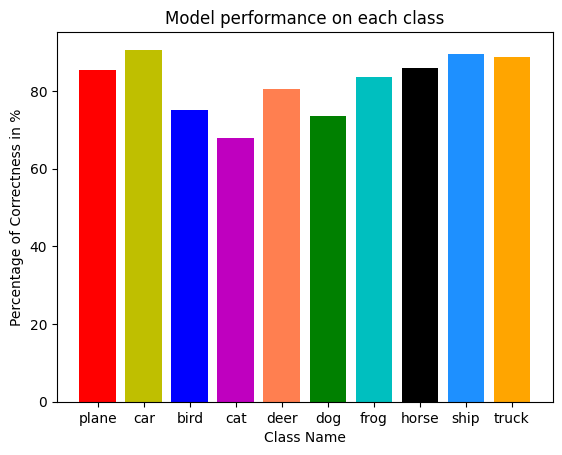

In [22]:
classes = ['plane','car','bird','cat','deer', 'dog','frog','horse','ship','truck']

for i, x in enumerate(all_class_correct):
    all_class_correct[i] = 100 * all_class_correct[i] / all_class_total[i]
print('all_class_correct', all_class_correct)


plt.bar(classes, all_class_correct, color=['r','y','b','m','coral','g','c','k','dodgerblue','orange'])
plt.title('Model performance on each class')
plt.xlabel('Class Name')#x轴
plt.ylabel('Percentage of Correctness in %')#y轴

plt.show()